In [47]:
import pandas as pd
import json
import numpy as np
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from typing import List, Iterable

# load data from jsonlines into pandas
with open("../datasets/interim/processed.jsonl", "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

line_dicts = [json.loads(line) for line in lines]
recipes = pd.DataFrame(line_dicts)
recipe_names = recipes["recipe_name"].values


In [48]:
# visualize word counts with histogram
def visualize_top_ngrams(words: Iterable[str],top_k: int, n: int):
    cutoff = 10  # discard n-grams with less than x occurrences
    # stop_words = ["39"]
    vectorizer = CountVectorizer(
    strip_accents="unicode", ngram_range=(n,n), min_df=cutoff, stop_words=None
)
    ngrams = vectorizer.fit_transform(words)
    ngram_df = (
        pd.DataFrame(
            data=ngrams.toarray(), columns=vectorizer.get_feature_names_out()
        )
        .sum(axis=0)
        .sort_values(ascending=True)
    )
    ngram_df.tail(top_k).plot(kind="barh") 
    plt.title(f'Counts of top {top_k} n-grams, $n={n}$')
    plt.xlabel('Counts')
    plt.show()
    return

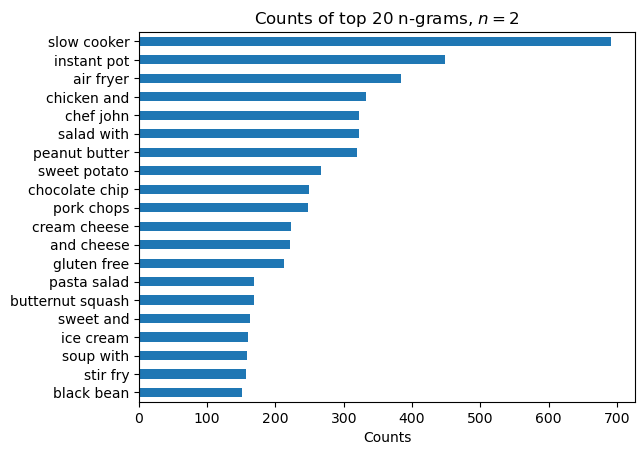

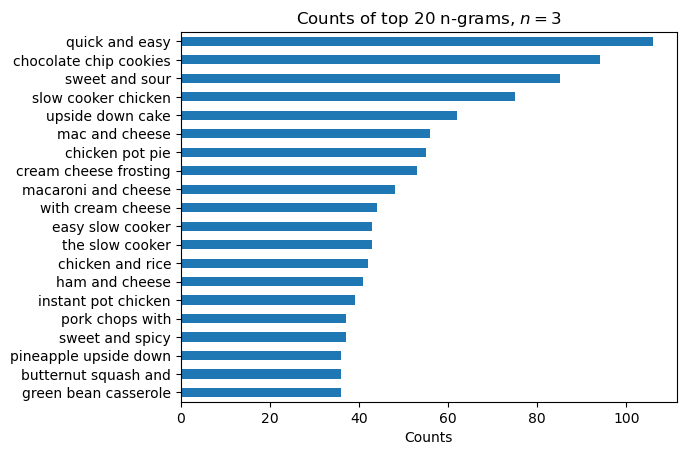

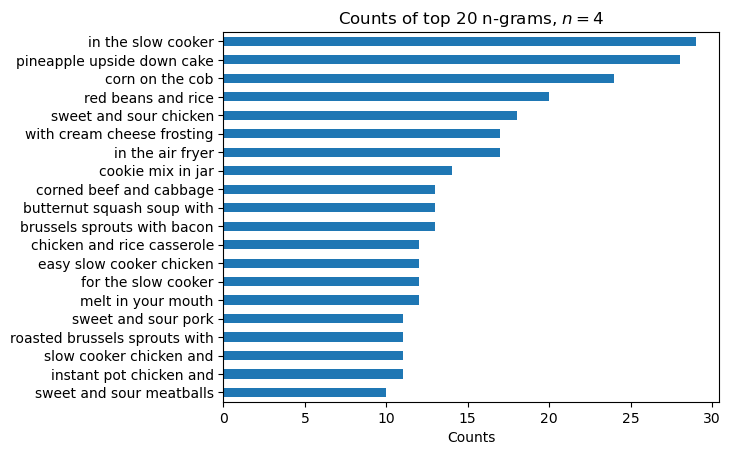

In [49]:
visualize_top_ngrams(recipe_names,20,2)
visualize_top_ngrams(recipe_names,20,3)
visualize_top_ngrams(recipe_names,20,4)

In [7]:
import chromadb
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# t-SNE

# load numpy vector embeddings from chroma
chroma_handle = chromadb.PersistentClient(path='../chroma_db_sample')
print(chroma_handle.list_collections())

[Collection(name=names), Collection(name=summed), Collection(name=instructions), Collection(name=ingredients)]


In [2]:
recipe_names = chroma_handle.get_collection(name='names')
stored_names = recipe_names.get(include=['embeddings', 'documents'])
embeddings = np.asarray(stored_names['embeddings'])
# Get subset of recipe names for easier visualization (35k is too many)
viz_names = pd.Series(stored_names['documents']).sample(n=50, random_state=3)
embeddings = embeddings[viz_names.index,:]

ValueError: Collection names does not exist.

In [60]:
viz_names.head()

24842                               No-Sweat Mojito
26771           Grilled Tuna Steaks with Dill Sauce
10054    Air Fryer Teriyaki Snap Peas and Mushrooms
28452                              Granola Bars III
17233                       Slow-Cooked Baked Beans
dtype: object

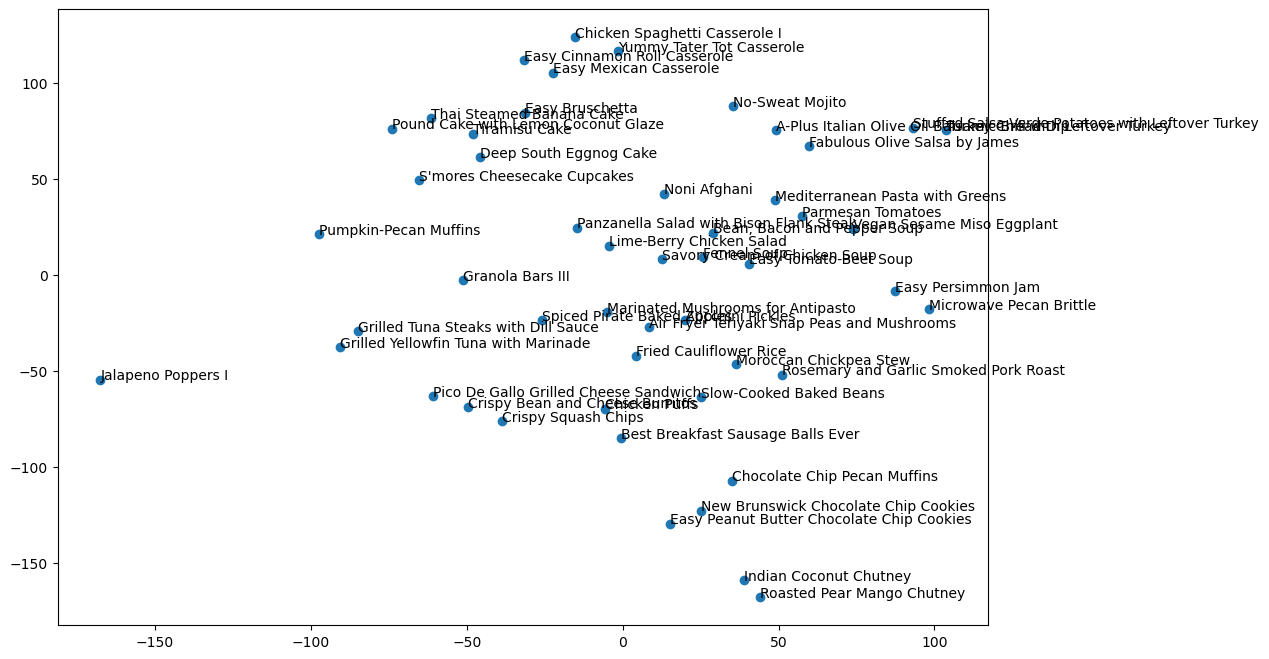

In [58]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, n_jobs=-1, perplexity=5, n_iter=1000)
reduc_embeddings = pca.fit_transform(embeddings)
tsne_embeddings = tsne.fit_transform(reduc_embeddings).T

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(tsne_embeddings[0], tsne_embeddings[1])

for i, name in enumerate(viz_names.values):
    ax.annotate(name, (tsne_embeddings[0,i], tsne_embeddings[1,i]))